# Score function analysis - Design choice

In [26]:
# Install required libraries (uncomment if needed)
# !pip install numpy matplotlib seaborn scikit-learn torchvision

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset


## Using a truncated version of CIFAR-10 dataset for faster training

In [ ]:
# Define transformations (keep RGB)
transform = transforms.Compose([
    transforms.Resize((16, 16)), 
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# Subset to 2000 images for faster training
subset_indices = np.random.choice(len(dataset), 3000,replace=False)
subset_dataset = Subset(dataset, subset_indices)

# Convert dataset to numpy format
X = np.array([np.array(img[0]).transpose(1, 2, 0) for img in subset_dataset])  # Keep RGB
y = np.array([img[1] for img in subset_dataset])  # Labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42)

print(f"Dataset Loaded: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Check new shapes
print(f"New shape of X_train: {X_train.shape}, X_test: {X_test.shape}")



/tmp/ipykernel_35655/1040447601.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X = np.array([np.array(img[0]).transpose(1, 2, 0) for img in subset_dataset])  # Keep RGB


Dataset Loaded: 1500 train samples, 1500 test samples
New shape of X_train: (1500, 3072), X_test: (1500, 3072)


### Training models - picking models of varying difficulties

In [36]:
# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=5),
    "Logistic Regression": LogisticRegression(max_iter=200)
}

# Train each model
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print("Done with", model)

# Evaluate models
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Training Naive Bayes...
Done with GaussianNB()
Training Decision Tree...
Done with DecisionTreeClassifier(max_depth=10)
Training Random Forest...
Done with RandomForestClassifier(max_depth=5, n_estimators=50)
Training Logistic Regression...


/home/siddharthrr/conformal_prediction/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done with LogisticRegression(max_iter=200)
Naive Bayes Accuracy: 0.2913
Decision Tree Accuracy: 0.2127
Random Forest Accuracy: 0.3053
Logistic Regression Accuracy: 0.2807


# Extracting probabilities to be used for creating the scores :

In [38]:
# Get probability predictions
proba_scores = {}
for name, model in trained_models.items():
    proba_scores[name] = model.predict_proba(X_test)

# Check score shapes
for name, scores in proba_scores.items():
    print(f"{name} score shape: {scores.shape}")


Naive Bayes score shape: (1500, 10)
Decision Tree score shape: (1500, 10)
Random Forest score shape: (1500, 10)
Logistic Regression score shape: (1500, 10)


In [41]:
# Number of calibration samples
n_cal = 500  

# Split test data into calibration and validation sets
X_cal, X_val = X_test[:n_cal], X_test[n_cal:]
y_cal, y_val = y_test[:n_cal], y_test[n_cal:]

# Flatten for models that require vector inputs
X_cal_flat = X_cal.reshape(n_cal, -1)
X_val_flat = X_val.reshape(len(X_val), -1)

print(f"Calibration set: {X_cal.shape[0]} samples, Validation set: {X_val.shape[0]} samples")


Calibration set: 500 samples, Validation set: 1000 samples


# Variouos types of score functions : 

In [ ]:
def compute_scores(probs, y_true):
    scores = {
        "1 - P(y | x)": 1 - probs[np.arange(len(y_true)), y_true],
        "-log P(y | x)": -np.log(probs[np.arange(len(y_true)), y_true] + 1e-9),  # Avoid log(0)
        "Entropy": -np.sum(probs * np.log(probs + 1e-9), axis=1),  # Total entropy of predictions
        "Margin": np.sort(probs, axis=1)[:, -1] - np.sort(probs, axis=1)[:, -2]  # Diff between top 2 probs
    }
    return scores


In [ ]:
def conformal_quantile(scores, alpha=0.1):
    """Compute the conformal prediction quantile threshold."""
    n = len(scores)
    q_hat = np.percentile(scores, 100 * (1 - alpha), interpolation="higher")
    return q_hat

# 50% Calibration samples
X_cal, X_test_final, y_cal, y_test_final = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Get probability scores for calibration
cal_proba_scores = {name: model.predict_proba(X_cal) for name, model in trained_models.items()}
test_proba_scores = {name: model.predict_proba(X_test_final) for name, model in trained_models.items()}

# Compute scores and quantiles
cal_scores = {name: compute_scores(probs, y_cal) for name, probs in cal_proba_scores.items()}
q_hat_values = {name: {score_name: conformal_quantile(score_values) for score_name, score_values in scores.items()} for name, scores in cal_scores.items()}


/tmp/ipykernel_35655/1245872974.py:16: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q_hat_values = {name: {score_name: conformal_quantile(score_values) for score_name, score_values in scores.items()} for name, scores in cal_scores.items()}


In [44]:
def compute_prediction_sets(probs, q_hat_values):
    """Compute prediction sets using different score functions."""
    prediction_sets = {}
    for score_name, q_hat in q_hat_values.items():
        if score_name == "1 - P(y | x)":
            pred_sets = probs >= (1 - q_hat)
        elif score_name == "-log P(y | x)":
            pred_sets = -np.log(probs + 1e-9) <= q_hat
        elif score_name == "Entropy":
            entropies = -np.sum(probs * np.log(probs + 1e-9), axis=1, keepdims=True)  # Expand dims
            pred_sets = entropies <= q_hat
        elif score_name == "Margin":
            sorted_probs = np.sort(probs, axis=1)
            margins = sorted_probs[:, -1][:, None] - sorted_probs[:, -2][:, None]  # Expand dims
            pred_sets = margins >= q_hat
        
        prediction_sets[score_name] = pred_sets
    
    return prediction_sets

# Compute prediction sets for test data
test_pred_sets = {name: compute_prediction_sets(probs, q_hat_values[name]) for name, probs in test_proba_scores.items()}


In [47]:
def compute_marginal_coverage(pred_sets, y_true, score_name):
    """Compute the probability that the true class belongs to the prediction set.
       For positively oriented scores (Entropy & Margin), use 1 - value.
    """
    if score_name in ["Entropy", "Margin"]:
        return 1 - np.mean([y in np.where(pred)[0] for y, pred in zip(y_true, pred_sets)])
    else:
        return np.mean([y in np.where(pred)[0] for y, pred in zip(y_true, pred_sets)])

# Compute updated marginal coverage results
marginal_coverage_results = {
    name: {
        score_name: compute_marginal_coverage(pred_set, y_test_final, score_name)
        for score_name, pred_set in pred_sets.items()
    }
    for name, pred_sets in test_pred_sets.items()
}


def compute_avg_set_size(pred_sets):
    """Compute the average prediction set size."""
    return np.mean([np.sum(pred) for pred in pred_sets])

# Compute results for all models and score functions
avg_set_size_results = {name: {score_name: compute_avg_set_size(pred_set) for score_name, pred_set in pred_sets.items()} for name, pred_sets in test_pred_sets.items()}


In [ ]:
import matplotlib.pyplot as plt

# Plot Marginal Coverage
plt.figure(figsize=(10,5))
for name, results in marginal_coverage_results.items():
    plt.plot(results.keys(), results.values(), marker="o", label=name)
plt.axhline(1 - 0.1, linestyle="--", color="black", label="Target Coverage")
plt.xticks(rotation=20)
plt.xlabel("Score Function")
plt.ylabel("Marginal Coverage")
plt.legend()
plt.title("Marginal Coverage for Different Score Functions")
plt.show()

# Plot Average Prediction Set Size
plt.figure(figsize=(10,5))
for name, results in avg_set_size_results.items():
    plt.plot(results.keys(), results.values(), marker="s", label=name)
plt.xticks(rotation=20)
plt.xlabel("Score Function")
plt.ylabel("Average Prediction Set Size")
plt.legend()
plt.title("Average Prediction Set Size for Different Score Functions")
plt.show()

: 


===== Model: Naive Bayes =====

  >> Score Function: 1 - P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



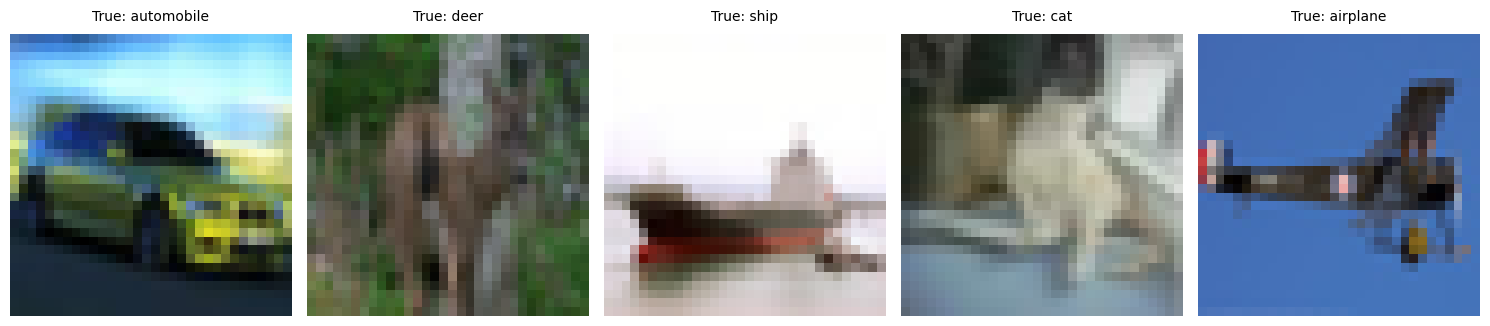


  >> Score Function: -log P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



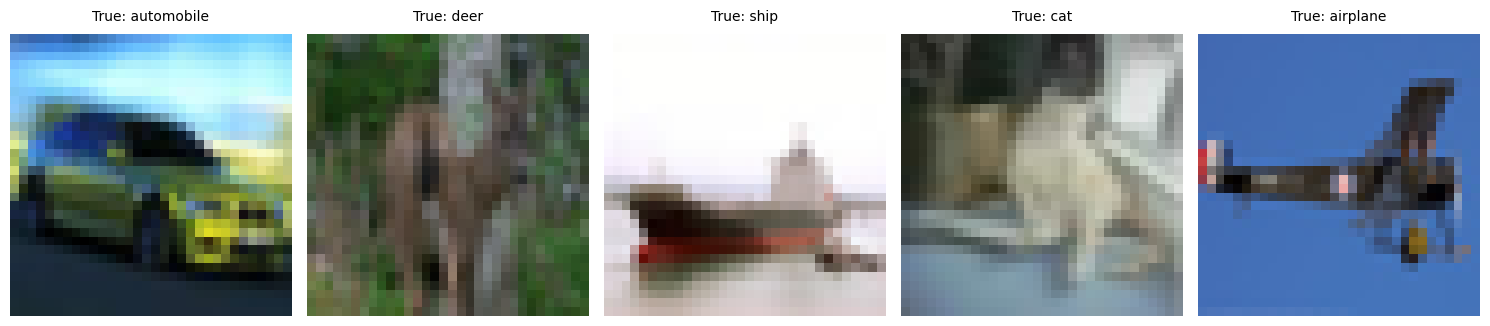


  >> Score Function: Entropy
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = ['airplane']

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = ['airplane']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



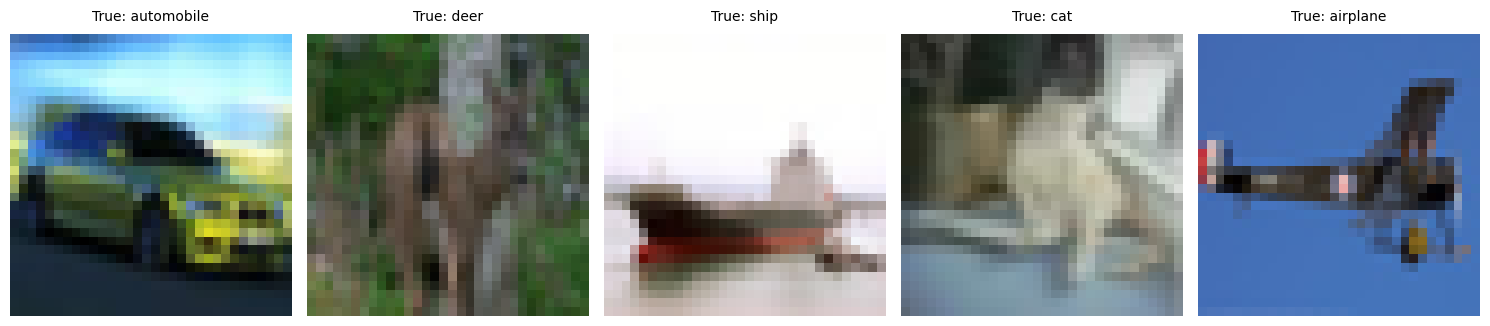


  >> Score Function: Margin
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = ['airplane']

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = ['airplane']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



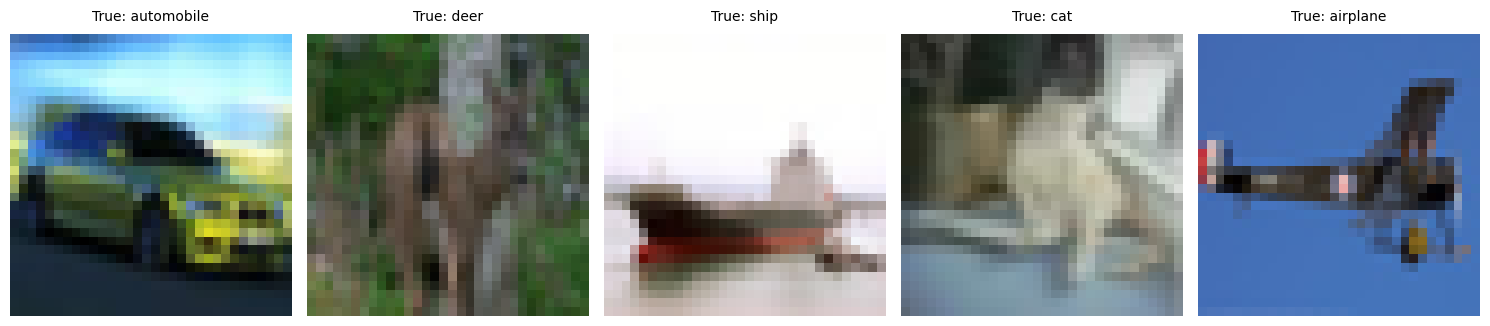


===== Model: Decision Tree =====

  >> Score Function: 1 - P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



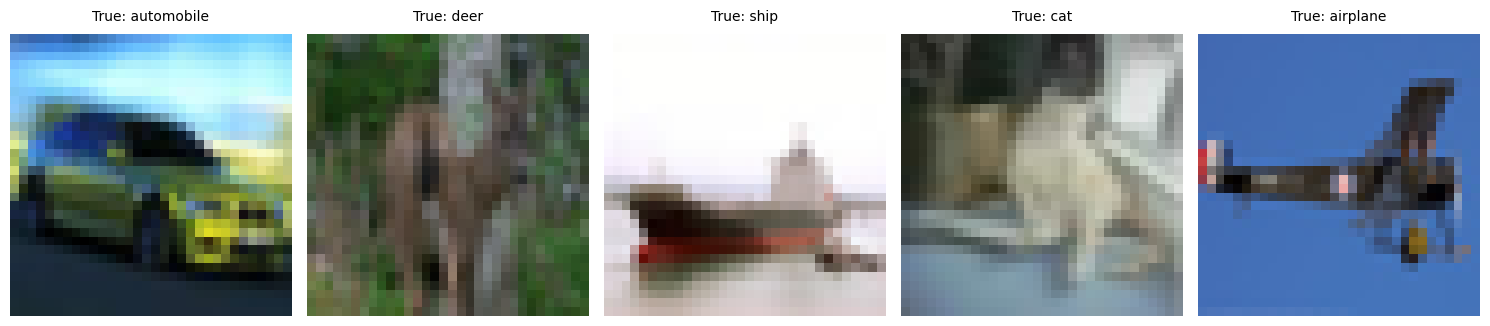


  >> Score Function: -log P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



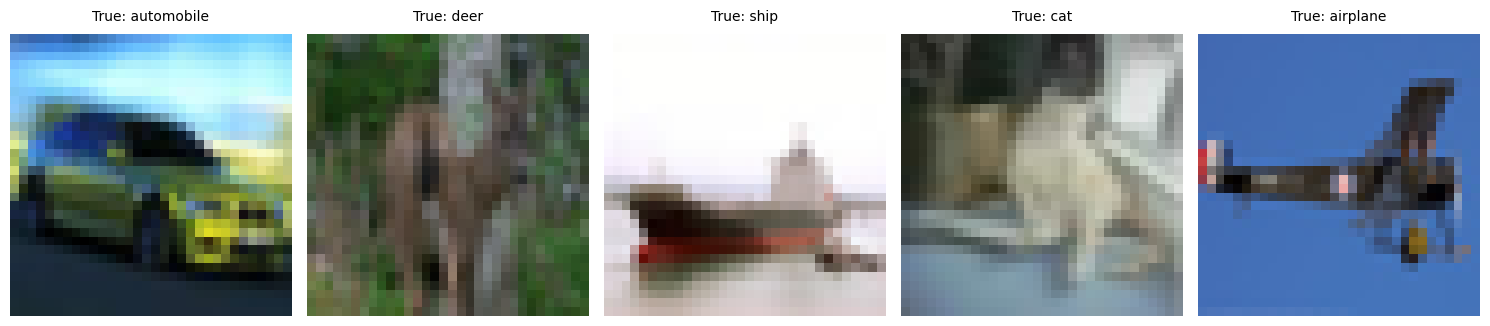


  >> Score Function: Entropy
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = ['airplane']

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = ['airplane']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



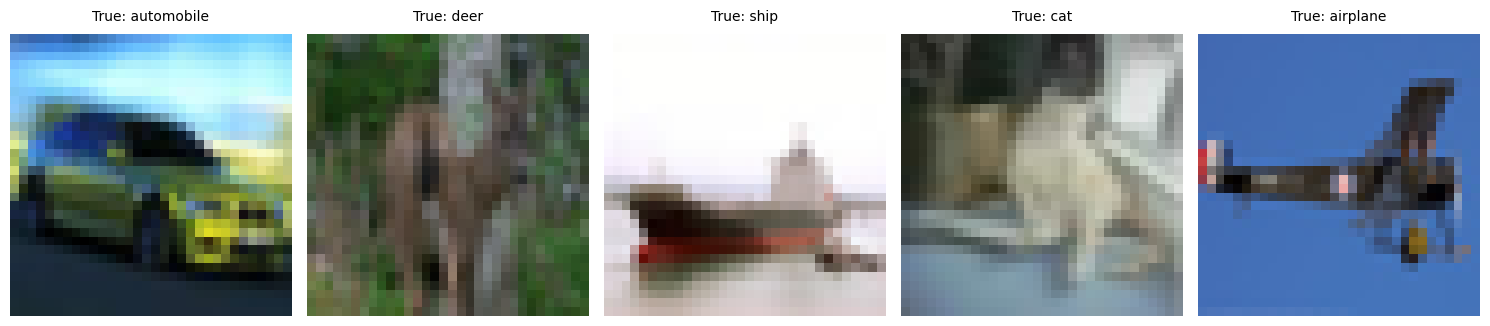


  >> Score Function: Margin
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = []

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = ['airplane']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



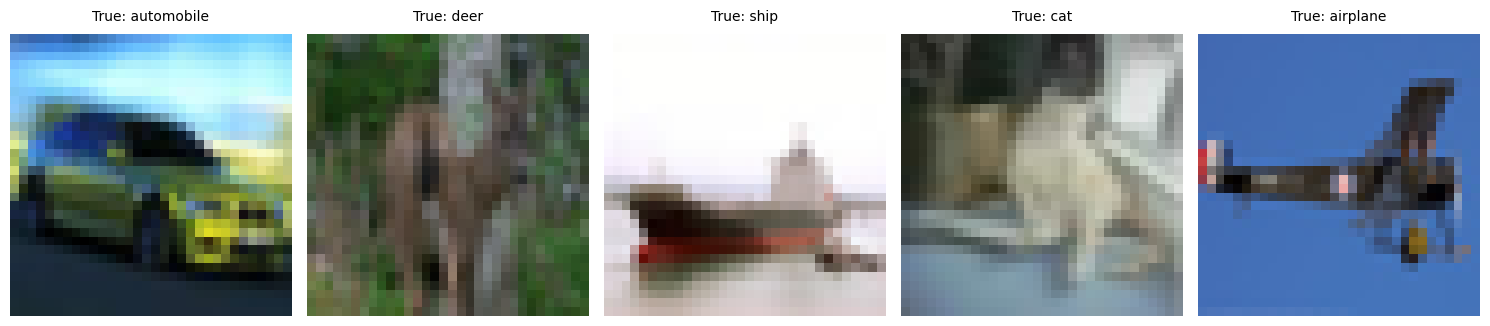


===== Model: Random Forest =====

  >> Score Function: 1 - P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'ship', 'truck']



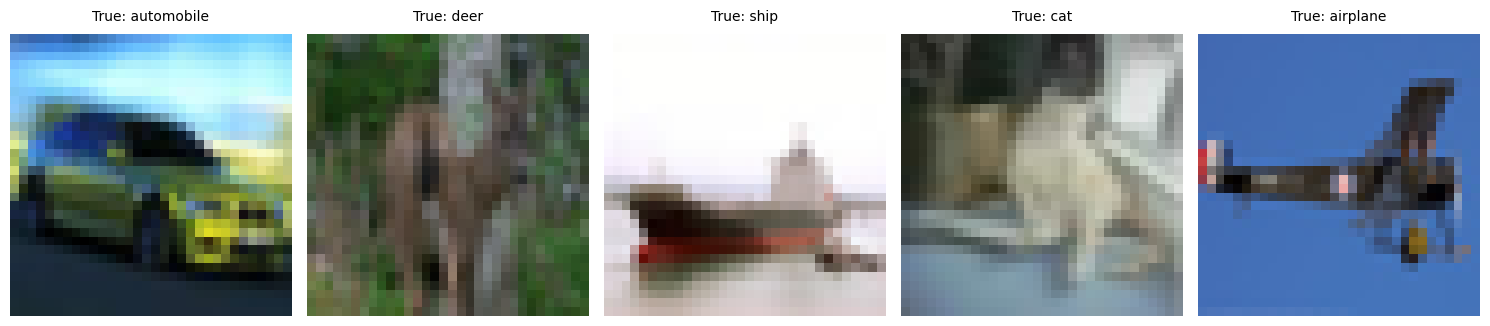


  >> Score Function: -log P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['airplane', 'automobile', 'bird', 'horse', 'ship', 'truck']

  Sample 2: True Class = deer
    Predicted Set = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'ship', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'ship', 'truck']



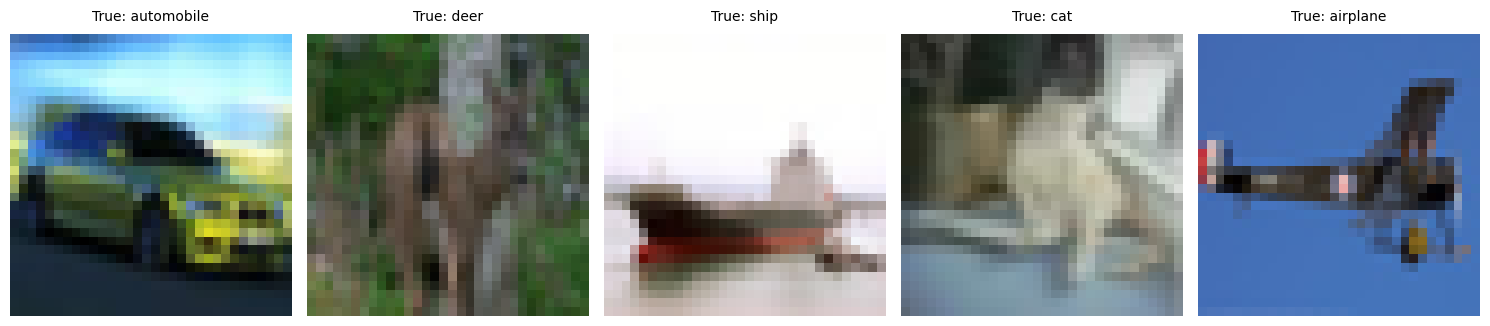


  >> Score Function: Entropy
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = ['airplane']

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = ['airplane']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



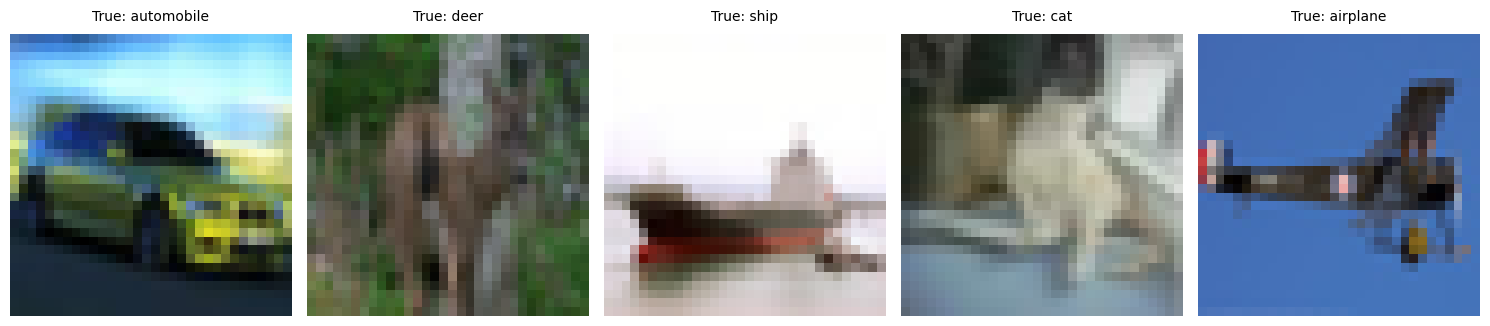


  >> Score Function: Margin
  Sample 1: True Class = automobile
    Predicted Set = []

  Sample 2: True Class = deer
    Predicted Set = []

  Sample 3: True Class = ship
    Predicted Set = []

  Sample 4: True Class = cat
    Predicted Set = []

  Sample 5: True Class = airplane
    Predicted Set = []



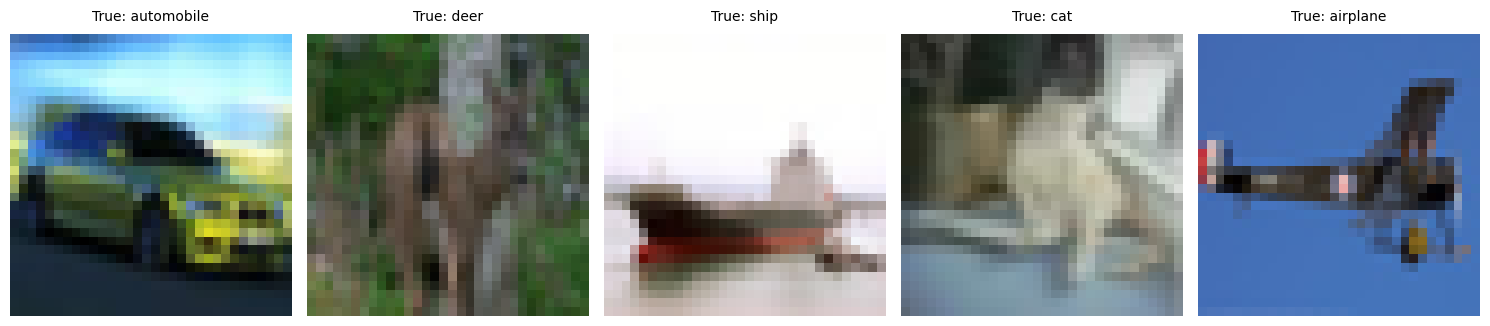


===== Model: Logistic Regression =====

  >> Score Function: 1 - P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['bird', 'horse', 'ship']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'deer', 'frog', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'dog', 'horse', 'ship', 'truck']



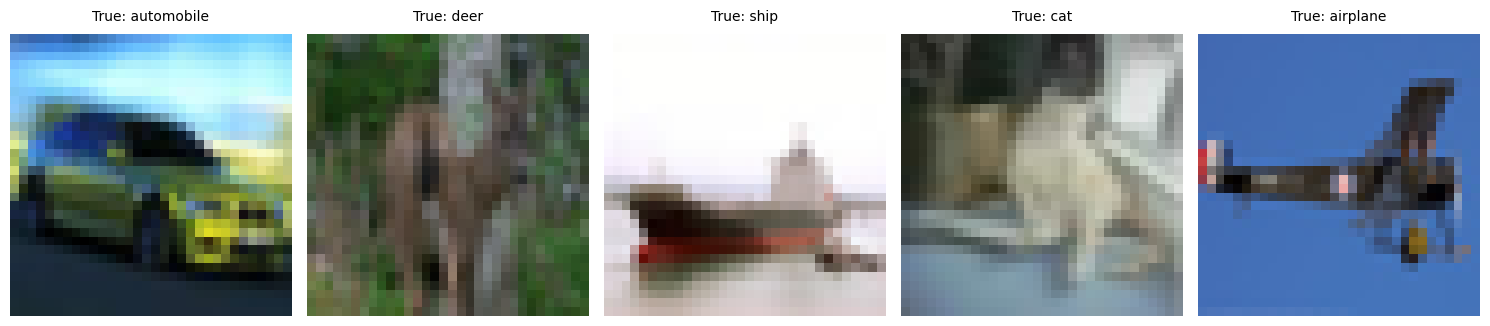


  >> Score Function: -log P(y | x)
  Sample 1: True Class = automobile
    Predicted Set = ['bird', 'horse', 'ship']

  Sample 2: True Class = deer
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  Sample 3: True Class = ship
    Predicted Set = ['airplane', 'automobile', 'deer', 'frog', 'truck']

  Sample 4: True Class = cat
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship']

  Sample 5: True Class = airplane
    Predicted Set = ['airplane', 'automobile', 'bird', 'cat', 'dog', 'horse', 'ship', 'truck']



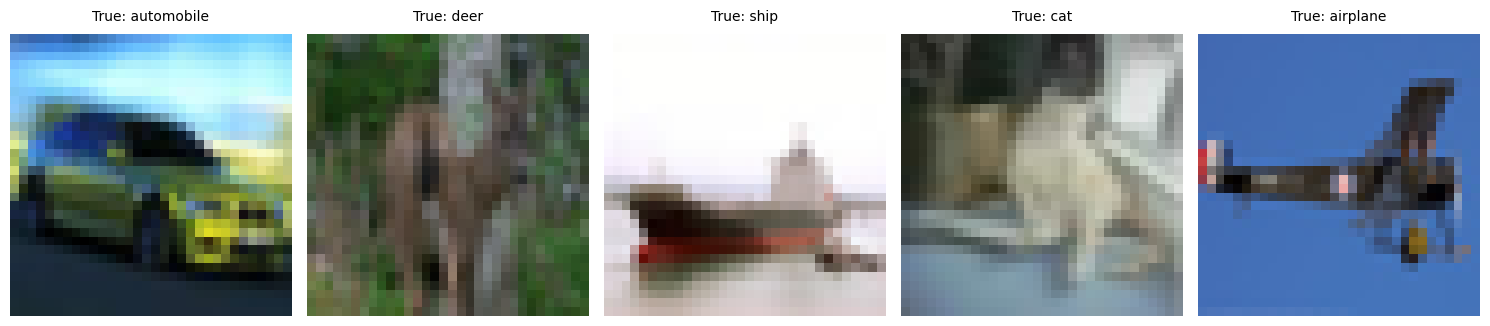


  >> Score Function: Entropy
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = []

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = []

  Sample 5: True Class = airplane
    Predicted Set = ['airplane']



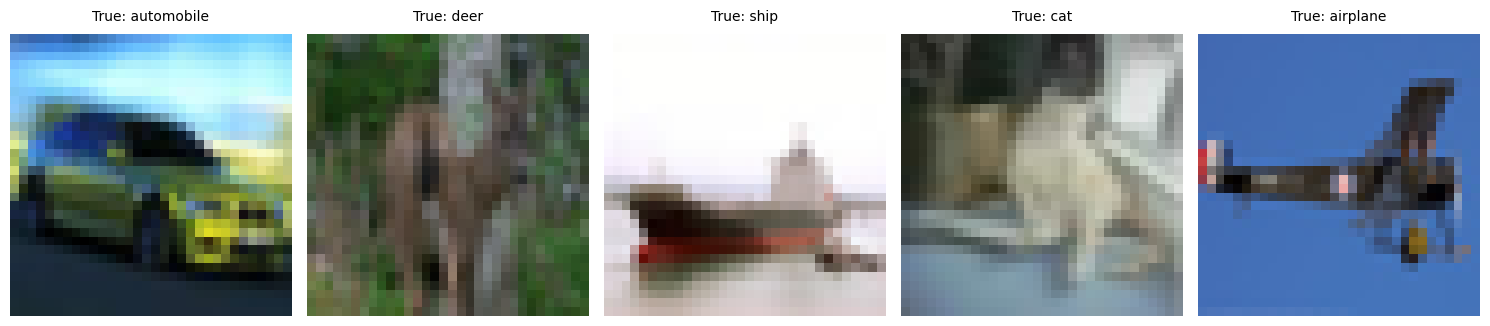


  >> Score Function: Margin
  Sample 1: True Class = automobile
    Predicted Set = ['airplane']

  Sample 2: True Class = deer
    Predicted Set = []

  Sample 3: True Class = ship
    Predicted Set = ['airplane']

  Sample 4: True Class = cat
    Predicted Set = []

  Sample 5: True Class = airplane
    Predicted Set = []



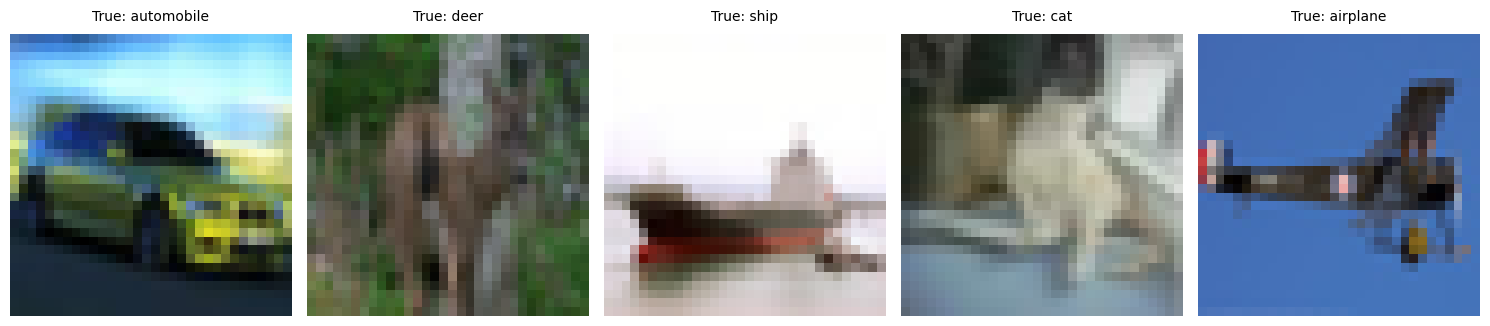

In [51]:
import textwrap

def plot_prediction_sets(sample_images, sample_labels, test_pred_sets, label_names):
    """
    Plots images along with their predicted class sets for each score function.
    Properly formats text to prevent overlapping.
    """
    for model_name, pred_sets in test_pred_sets.items():
        print(f"\n===== Model: {model_name} =====")

        for score_name, pred_set in pred_sets.items():
            print(f"\n  >> Score Function: {score_name}")

            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))  # Wider layout

            for i, idx in enumerate(sample_indices):
                ax = axes[i]
                ax.imshow(sample_images[i])
                ax.axis("off")

                # Get the predicted set for this sample
                predicted_classes = np.where(pred_set[idx])[0]
                predicted_labels = [label_names[p] for p in predicted_classes]

                # Print the prediction set
                print(f"  Sample {i+1}: True Class = {label_names[sample_labels[i]]}")
                print(f"    Predicted Set = {predicted_labels}\n")

                # Format text properly (wrap if long)
                pred_text = "\n".join(textwrap.wrap(", ".join(predicted_labels), width=15))

                # Set title with proper spacing
                ax.set_title(f"True: {label_names[sample_labels[i]]}", fontsize=10, pad=10)
                ax.set_xlabel(pred_text, fontsize=8)

            plt.tight_layout()
            plt.show()

# Plot with printed class sets
plot_prediction_sets(sample_images, sample_labels, test_pred_sets, label_names)
